In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from utils import *
from models import *
from pprint import pp

In [21]:
# sns.set_style("white")
sns.set_palette(sns.color_palette("pastel"))

In [22]:
data = pd.read_csv("fetal_health.csv")
data.fetal_health = pd.Categorical(data.fetal_health, categories=[1.0, 2.0, 3.0], ordered=True)

In [23]:
X = data.drop('fetal_health', axis=1)
y = data.fetal_health

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1700, 21) (1700,)
(426, 21) (426,)


## KNN

### K opt

Données brutes


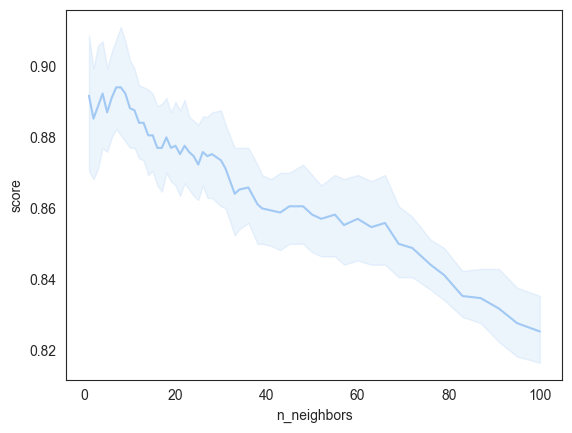

Best k: 7 with a score of: 0.8941176470588236



Données normalisées


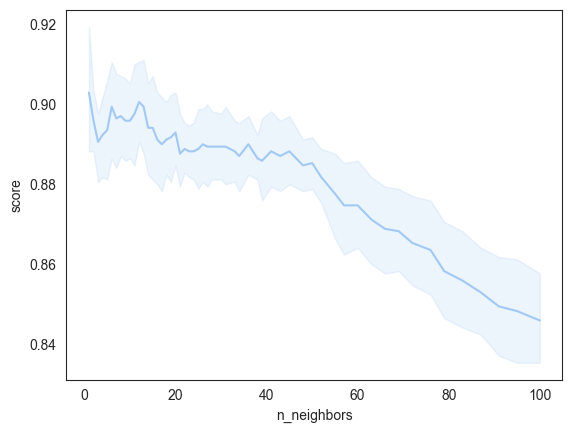

Best k: 1 with a score of: 0.9029411764705882



Données brutes avec SV


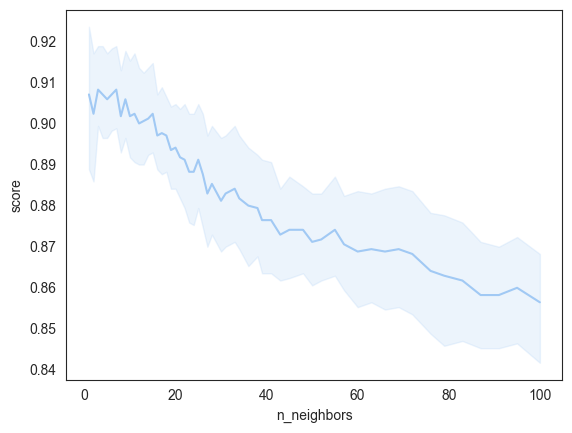

Best k: 3 with a score of: 0.908235294117647



Données normalisées avec SV


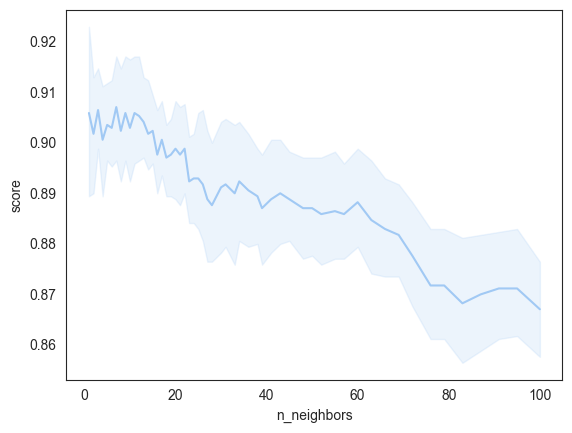

Best k: 7 with a score of: 0.9070588235294117





In [6]:
n_neighbors_list = np.unique(np.round(np.geomspace(1, 100, 100)).astype(int))
for pipeline_name, pipeline in pipelines:
    X_train_processed = pipeline.fit_transform(X_train, y_train)
    print(pipeline_name)
    select_k_opt(X_train_processed, y_train, 10, n_neighbors_list)
    print("\n\n")

B
{'recalls_path': [0.8571428571428571,
                  0.7142857142857143,
                  0.5714285714285714,
                  0.6428571428571429,
                  0.7857142857142857,
                  0.7142857142857143,
                  0.9285714285714286,
                  0.7857142857142857,
                  0.7142857142857143,
                  0.6],
 'accuracies': [0.9294117647058824,
                0.888235294117647,
                0.8764705882352941,
                0.9294117647058824,
                0.8823529411764706,
                0.8823529411764706,
                0.9058823529411765,
                0.8705882352941177,
                0.8941176470588236,
                0.8823529411764706],
 'recall_path_test': 0.7428571428571429,
 'accuracy_test': 0.8755868544600939}

N
{'recalls_path': [0.8571428571428571,
                  0.7142857142857143,
                  0.7857142857142857,
                  0.7857142857142857,
                  0.7857142857142857,


<module 'matplotlib.pyplot' from 'C:\\Users\\Beziat\\PycharmProjects\\SY09-Data\\.venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

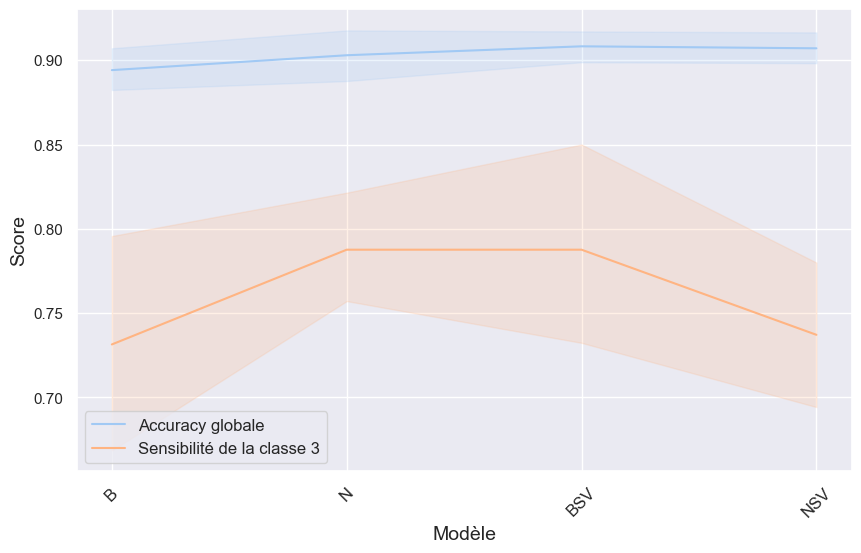

In [25]:
results_knn = {}

for pipeline_name, pipeline, k_opt in knn_models:
    print(pipeline_name)
    results_knn[pipeline_name] = evaluate_model(
        pipeline, 
        KNeighborsClassifier(n_neighbors=k_opt), 
        X_train, 
        y_train, 
        X_test, 
        y_test
    )
    pp(results_knn[pipeline_name])
    print()


model_names = []
accuracies = []
recalls = []

for model_name, result in results_knn.items():
    model_names.extend([model_name] * len(result["accuracies"]))
    accuracies.extend(result["accuracies"])
    recalls.extend(result["recalls_path"])


df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "Recall": recalls
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Model", y="Accuracy", label="Accuracy globale")
sns.lineplot(data=df, x="Model", y="Recall", label="Sensibilité de la classe 3")
plt.xlabel("Modèle",  fontsize=14)
plt.ylabel("Score",  fontsize=14)
plt.xticks(rotation=45,  fontsize=12)
plt.legend( fontsize=12)
plt


Le meilleur modèle est Données brutes avec SV, tant en terme d'accuracy que de sensibilité pour la classe 3.

Meilleur KNN : k = 3, données brutes, sélection de variables.
Accuracy globale (CrossVal) : 0.908
Rappel classe Pathological (CrossVal) : 0.788

Matrice de confusion :


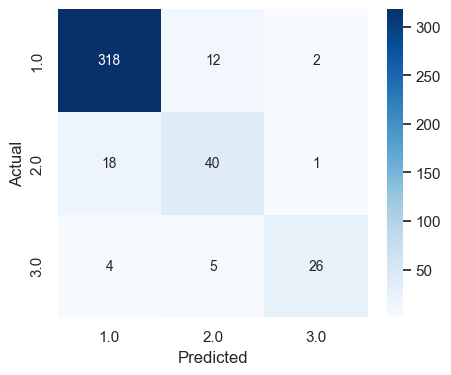

Rapport de classification sur le jeu de test : 
              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95       332
         2.0       0.70      0.68      0.69        59
         3.0       0.90      0.74      0.81        35

    accuracy                           0.90       426
   macro avg       0.84      0.79      0.82       426
weighted avg       0.90      0.90      0.90       426



In [8]:
best_knn = results_knn["BSV"]
print("Meilleur KNN : k = 3, données brutes, sélection de variables.")
print(f"Accuracy globale (CrossVal) : {np.mean(best_knn['accuracies']):.3f}")
print(f"Rappel classe Pathological (CrossVal) : {np.mean(best_knn['recalls_path']):.3f}\n")

pipeline = Pipeline([
    ("Standardization", FunctionTransformer(validate=True)),
    ("FeatureSelection", SelectKBest(score_func=f_classif, k=6))
])

X_train_processed = pipeline.fit_transform(X_train, y_train)

best_model = KNeighborsClassifier(n_neighbors=3)
best_model.fit(X_train_processed, y_train)

X_test_processed = pipeline.transform(X_test)

y_test_pred = best_model.predict(X_test_processed)

print("Matrice de confusion :")
cm = confusion_matrix(y_test, y_test_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,4))
sns.set(font_scale=1)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 10})
plt.show()

print("Rapport de classification sur le jeu de test : ")
print(classification_report(y_test, y_test_pred))

## Analyse Discriminante

### LDA

B
{'recalls_path': [0.5714285714285714,
                  0.7857142857142857,
                  0.6428571428571429,
                  0.5,
                  0.5,
                  0.5,
                  0.7142857142857143,
                  0.7142857142857143,
                  0.7857142857142857,
                  0.6],
 'accuracies': [0.8823529411764706,
                0.8941176470588236,
                0.8588235294117647,
                0.9176470588235294,
                0.8647058823529412,
                0.8529411764705882,
                0.9176470588235294,
                0.8411764705882353,
                0.9,
                0.8705882352941177],
 'recall_path_test': 0.5428571428571428,
 'accuracy_test': 0.8474178403755869}

N
{'recalls_path': [0.5714285714285714,
                  0.7857142857142857,
                  0.6428571428571429,
                  0.5,
                  0.5,
                  0.5,
                  0.7142857142857143,
                  0.71428571

<module 'matplotlib.pyplot' from 'C:\\Users\\Beziat\\PycharmProjects\\SY09-Data\\.venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

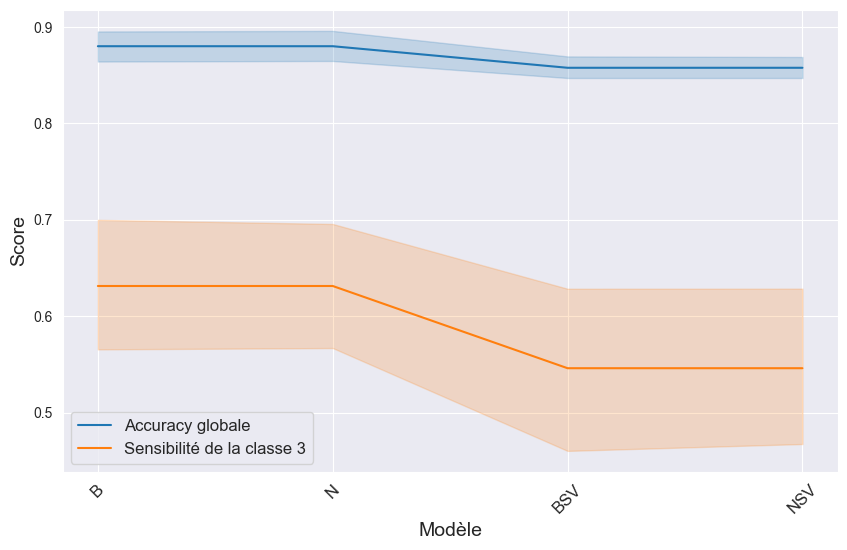

In [5]:
results_lda = {}

for pipeline_name, pipeline in lda_models:
    print(pipeline_name)
    results_lda[pipeline_name] = evaluate_model(
        pipeline, 
        LinearDiscriminantAnalysis(), 
        X_train, 
        y_train, 
        X_test, 
        y_test
    )
    pp(results_lda[pipeline_name])
    print()


model_names = []
accuracies = []
recalls = []

for model_name, result in results_lda.items():
    model_names.extend([model_name] * len(result["accuracies"]))
    accuracies.extend(result["accuracies"])
    recalls.extend(result["recalls_path"])


df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "Recall": recalls
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Model", y="Accuracy", label="Accuracy globale")
sns.lineplot(data=df, x="Model", y="Recall", label="Sensibilité de la classe 3")
plt.xlabel("Modèle",  fontsize=14)
plt.ylabel("Score",  fontsize=14)
plt.xticks(rotation=45,  fontsize=12)
plt.legend( fontsize=12)
plt


Meilleure LDA : données brutes.
Accuracy globale (CrossVal) : 0.880
Rappel classe Pathological (CrossVal) : 0.631

Matrice de confusion :


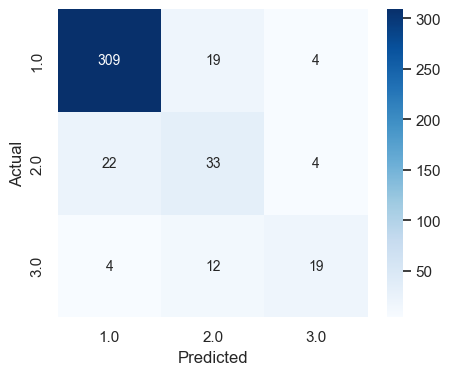

Rapport de classification sur le jeu de test : 
              precision    recall  f1-score   support

         1.0       0.92      0.93      0.93       332
         2.0       0.52      0.56      0.54        59
         3.0       0.70      0.54      0.61        35

    accuracy                           0.85       426
   macro avg       0.71      0.68      0.69       426
weighted avg       0.85      0.85      0.85       426



In [6]:
best_lda = results_lda["B"]
print("Meilleure LDA : données brutes.")
print(f"Accuracy globale (CrossVal) : {np.mean(best_lda['accuracies']):.3f}")
print(f"Rappel classe Pathological (CrossVal) : {np.mean(best_lda['recalls_path']):.3f}\n")

pipeline = Pipeline([
    ("Standardization", FunctionTransformer(validate=True)),
])

X_train_processed = pipeline.fit_transform(X_train, y_train)

best_model = LinearDiscriminantAnalysis()
best_model.fit(X_train_processed, y_train)

X_test_processed = pipeline.transform(X_test)

y_test_pred = best_model.predict(X_test_processed)

print("Matrice de confusion :")
cm = confusion_matrix(y_test, y_test_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,4))
sns.set(font_scale=1)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 10})
plt.show()

print("Rapport de classification sur le jeu de test : ")
print(classification_report(y_test, y_test_pred))

### QDA

B
0.7805882352941176
0.7319047619047618
{'recalls_path': [0.7142857142857143,
                  0.8571428571428571,
                  0.7857142857142857,
                  0.7142857142857143,
                  0.8571428571428571,
                  0.7857142857142857,
                  0.7142857142857143,
                  0.5714285714285714,
                  0.7857142857142857,
                  0.5333333333333333],
 'accuracies': [0.711764705882353,
                0.8235294117647058,
                0.8294117647058824,
                0.8294117647058824,
                0.8411764705882353,
                0.8235294117647058,
                0.6823529411764706,
                0.7411764705882353,
                0.7176470588235294,
                0.8058823529411765],
 'recall_path_test': 0.6285714285714286,
 'accuracy_test': 0.7206572769953051}

N
0.7088235294117647
0.5823809523809523
{'recalls_path': [0.42857142857142855,
                  0.8571428571428571,
                  0.57

<module 'matplotlib.pyplot' from 'C:\\Users\\Beziat\\PycharmProjects\\SY09-Data\\.venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

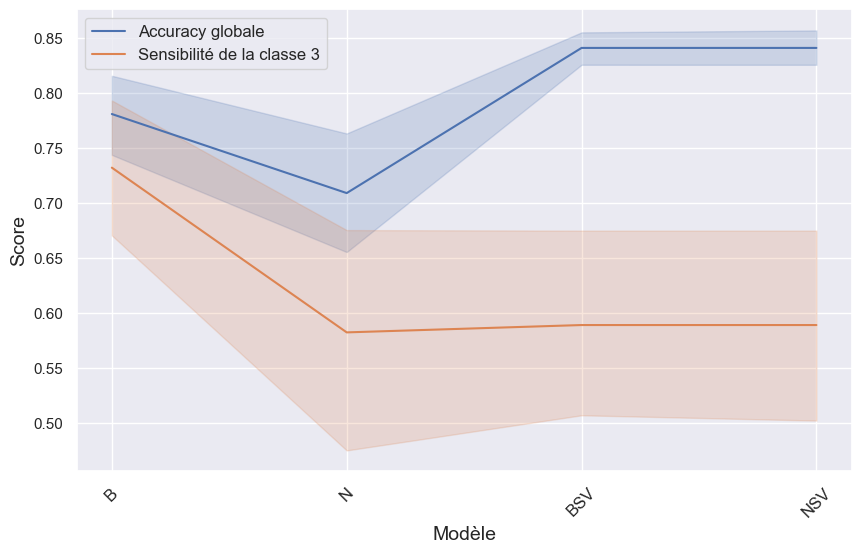

In [7]:
import warnings
warnings.filterwarnings("ignore")

results_qda = {}

for pipeline_name, pipeline in qda_models:
    print(pipeline_name)
    results_qda[pipeline_name] = evaluate_model(
        pipeline, 
        QuadraticDiscriminantAnalysis(), 
        X_train, 
        y_train, 
        X_test, 
        y_test
    )
    print(np.mean(results_qda[pipeline_name]['accuracies']))
    print(np.mean(results_qda[pipeline_name]['recalls_path']))
    pp(results_qda[pipeline_name])
    print()


model_names = []
accuracies = []
recalls = []

for model_name, result in results_qda.items():
    model_names.extend([model_name] * len(result["accuracies"]))
    accuracies.extend(result["accuracies"])
    recalls.extend(result["recalls_path"])


df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "Recall": recalls
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Model", y="Accuracy", label="Accuracy globale")
sns.lineplot(data=df, x="Model", y="Recall", label="Sensibilité de la classe 3")
plt.xlabel("Modèle",  fontsize=14)
plt.ylabel("Score",  fontsize=14)
plt.xticks(rotation=45,  fontsize=12)
plt.legend( fontsize=12)
plt

Meilleure QDA : données brutes.
Accuracy globale (CrossVal) : 0.781
Rappel classe Pathological (CrossVal) : 0.732

Matrice de confusion :


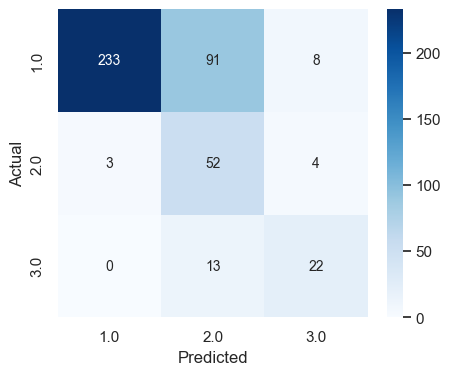

Rapport de classification sur le jeu de test : 
              precision    recall  f1-score   support

         1.0       0.99      0.70      0.82       332
         2.0       0.33      0.88      0.48        59
         3.0       0.65      0.63      0.64        35

    accuracy                           0.72       426
   macro avg       0.66      0.74      0.65       426
weighted avg       0.87      0.72      0.76       426



In [8]:
best_qda = results_qda["B"] # Dépend de si on se base sur le recall de la classe 3 ou l'accuracy (j'ai pris le recall ici)
print("Meilleure QDA : données brutes.")
print(f"Accuracy globale (CrossVal) : {np.mean(best_qda['accuracies']):.3f}")
print(f"Rappel classe Pathological (CrossVal) : {np.mean(best_qda['recalls_path']):.3f}\n")

pipeline = Pipeline([
    ("Standardization", FunctionTransformer(validate=True)),
])

X_train_processed = pipeline.fit_transform(X_train, y_train)

best_model = QuadraticDiscriminantAnalysis()
best_model.fit(X_train_processed, y_train)

X_test_processed = pipeline.transform(X_test)

y_test_pred = best_model.predict(X_test_processed)

print("Matrice de confusion :")
cm = confusion_matrix(y_test, y_test_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,4))
sns.set(font_scale=1)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 10})
plt.show()

print("Rapport de classification sur le jeu de test : ")
print(classification_report(y_test, y_test_pred))

### NB

B
{'recalls_path': [0.5714285714285714,
                  0.7142857142857143,
                  0.5714285714285714,
                  0.42857142857142855,
                  0.5714285714285714,
                  0.6428571428571429,
                  0.7857142857142857,
                  0.7857142857142857,
                  0.7857142857142857,
                  0.6],
 'accuracies': [0.8,
                0.8647058823529412,
                0.8235294117647058,
                0.8,
                0.8058823529411765,
                0.7941176470588235,
                0.8235294117647058,
                0.8117647058823529,
                0.8352941176470589,
                0.8058823529411765],
 'recall_path_test': 0.6,
 'accuracy_test': 0.8004694835680751}

N
{'recalls_path': [0.42857142857142855,
                  0.8571428571428571,
                  0.6428571428571429,
                  0.35714285714285715,
                  0.5714285714285714,
                  0.5,
                  

<module 'matplotlib.pyplot' from 'C:\\Users\\Beziat\\PycharmProjects\\SY09-Data\\.venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

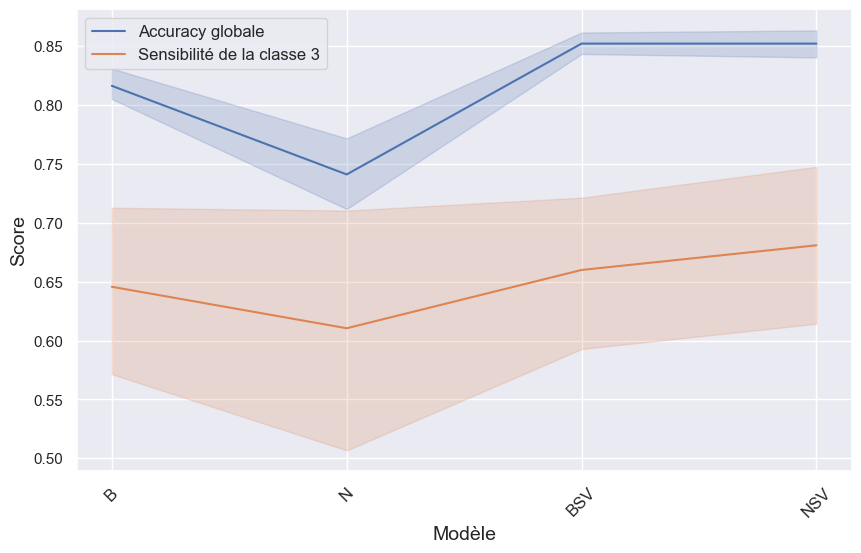

In [9]:
results_nb = {}

for pipeline_name, pipeline in nb_models:
    print(pipeline_name)
    results_nb[pipeline_name] = evaluate_model(
        pipeline, 
        GaussianNB(), 
        X_train, 
        y_train, 
        X_test, 
        y_test
    )
    pp(results_nb[pipeline_name])
    print()


model_names = []
accuracies = []
recalls = []

for model_name, result in results_nb.items():
    model_names.extend([model_name] * len(result["accuracies"]))
    accuracies.extend(result["accuracies"])
    recalls.extend(result["recalls_path"])


df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "Recall": recalls
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Model", y="Accuracy", label="Accuracy globale")
sns.lineplot(data=df, x="Model", y="Recall", label="Sensibilité de la classe 3")
plt.xlabel("Modèle",  fontsize=14)
plt.ylabel("Score",  fontsize=14)
plt.xticks(rotation=45,  fontsize=12)
plt.legend( fontsize=12)
plt


Meilleure NB : données normalisées avec SV.
Accuracy globale (CrossVal) : 0.852
Rappel classe Pathological (CrossVal) : 0.681

Matrice de confusion :


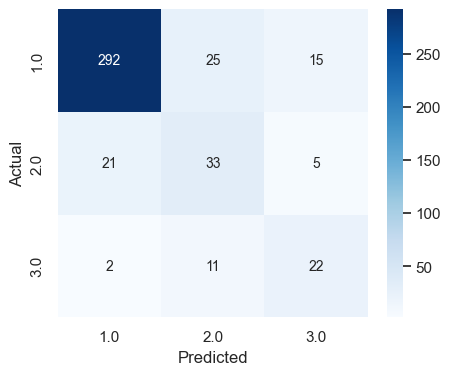

Rapport de classification sur le jeu de test : 
              precision    recall  f1-score   support

         1.0       0.93      0.88      0.90       332
         2.0       0.48      0.56      0.52        59
         3.0       0.52      0.63      0.57        35

    accuracy                           0.81       426
   macro avg       0.64      0.69      0.66       426
weighted avg       0.83      0.81      0.82       426



In [10]:
best_nb = results_nb["NSV"]
print("Meilleure NB : données normalisées avec SV.")
print(f"Accuracy globale (CrossVal) : {np.mean(best_nb['accuracies']):.3f}")
print(f"Rappel classe Pathological (CrossVal) : {np.mean(best_nb['recalls_path']):.3f}\n")

pipeline = Pipeline([
        ("Standardization", StandardScaler()),
        ("FeatureSelection", SelectKBest(score_func=f_classif, k=6))
])

X_train_processed = pipeline.fit_transform(X_train, y_train)

best_model = GaussianNB()
best_model.fit(X_train_processed, y_train)

X_test_processed = pipeline.transform(X_test)

y_test_pred = best_model.predict(X_test_processed)

print("Matrice de confusion :")
cm = confusion_matrix(y_test, y_test_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,4))
sns.set(font_scale=1)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 10})
plt.show()

print("Rapport de classification sur le jeu de test : ")
print(classification_report(y_test, y_test_pred))

## Régression logistique

B
{'recalls_path': [0.7857142857142857,
                  0.7142857142857143,
                  0.5714285714285714,
                  0.5714285714285714,
                  0.7142857142857143,
                  0.8571428571428571,
                  0.7857142857142857,
                  1.0,
                  0.7142857142857143,
                  0.6],
 'accuracies': [0.8941176470588236,
                0.8705882352941177,
                0.8411764705882353,
                0.8764705882352941,
                0.8647058823529412,
                0.8764705882352941,
                0.8588235294117647,
                0.8823529411764706,
                0.8647058823529412,
                0.8411764705882353],
 'recall_path_test': 0.7428571428571429,
 'accuracy_test': 0.8450704225352113}

N
{'recalls_path': [0.7142857142857143,
                  0.8571428571428571,
                  0.7857142857142857,
                  0.5714285714285714,
                  0.7857142857142857,
              

<module 'matplotlib.pyplot' from 'C:\\Users\\Beziat\\PycharmProjects\\SY09-Data\\.venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

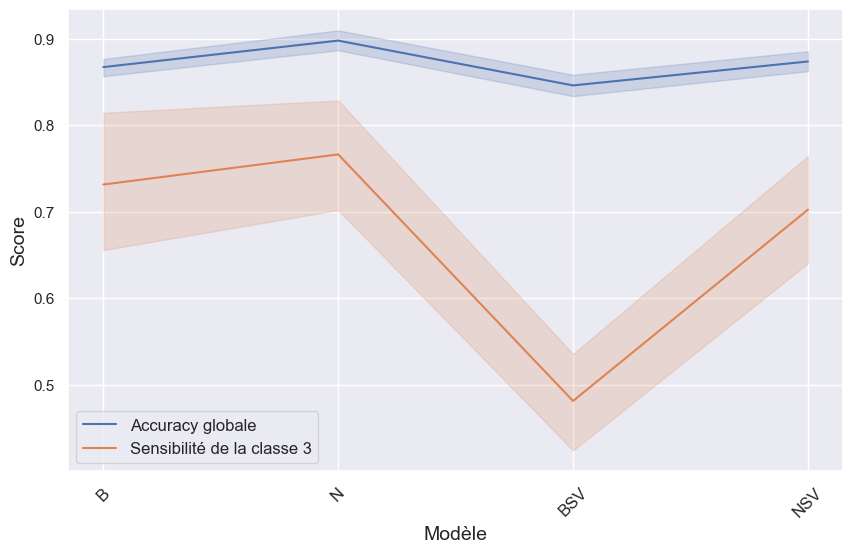

In [16]:
results_lr = {}

for pipeline_name, pipeline in lr_models:
    print(pipeline_name)
    results_lr[pipeline_name] = evaluate_model(
        pipeline, 
        LogisticRegression(max_iter=100), 
        X_train, 
        y_train, 
        X_test, 
        y_test
    )
    pp(results_lr[pipeline_name])
    print()


model_names = []
accuracies = []
recalls = []

for model_name, result in results_lr.items():
    model_names.extend([model_name] * len(result["accuracies"]))
    accuracies.extend(result["accuracies"])
    recalls.extend(result["recalls_path"])


df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "Recall": recalls
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Model", y="Accuracy", label="Accuracy globale")
sns.lineplot(data=df, x="Model", y="Recall", label="Sensibilité de la classe 3")
plt.xlabel("Modèle",  fontsize=14)
plt.ylabel("Score",  fontsize=14)
plt.xticks(rotation=45,  fontsize=12)
plt.legend( fontsize=12)
plt


Meilleure LR : données normalisées.
Accuracy globale (CrossVal) : 0.898
Rappel classe Pathological (CrossVal) : 0.766

Matrice de confusion :


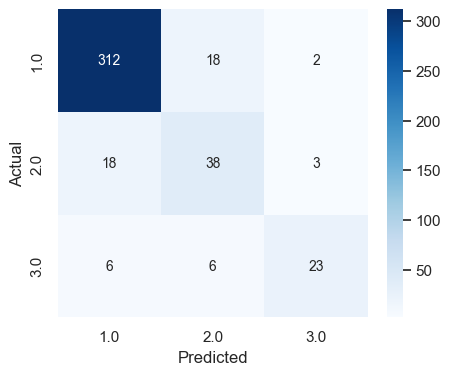

Rapport de classification sur le jeu de test : 
              precision    recall  f1-score   support

         1.0       0.93      0.94      0.93       332
         2.0       0.61      0.64      0.63        59
         3.0       0.82      0.66      0.73        35

    accuracy                           0.88       426
   macro avg       0.79      0.75      0.76       426
weighted avg       0.88      0.88      0.87       426



In [17]:
best_lr = results_lr["N"]
print("Meilleure LR : données normalisées.")
print(f"Accuracy globale (CrossVal) : {np.mean(best_lr['accuracies']):.3f}")
print(f"Rappel classe Pathological (CrossVal) : {np.mean(best_lr['recalls_path']):.3f}\n")

pipeline = Pipeline([
        ("Standardization", StandardScaler()),
])

X_train_processed = pipeline.fit_transform(X_train, y_train)

best_model = LogisticRegression()
best_model.fit(X_train_processed, y_train)

X_test_processed = pipeline.transform(X_test)

y_test_pred = best_model.predict(X_test_processed)

print("Matrice de confusion :")
cm = confusion_matrix(y_test, y_test_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,4))
sns.set(font_scale=1)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 10})
plt.show()

print("Rapport de classification sur le jeu de test : ")
print(classification_report(y_test, y_test_pred))

## Arbres de décision

B
{'recalls_path': [1.0,
                  0.7857142857142857,
                  0.8571428571428571,
                  0.8571428571428571,
                  0.9285714285714286,
                  1.0,
                  1.0,
                  1.0,
                  0.8571428571428571,
                  0.8],
 'accuracies': [0.9470588235294117,
                0.9176470588235294,
                0.9058823529411765,
                0.9529411764705882,
                0.9,
                0.9176470588235294,
                0.9352941176470588,
                0.8764705882352941,
                0.9117647058823529,
                0.9235294117647059],
 'recall_path_test': 0.8571428571428571,
 'accuracy_test': 0.9272300469483568}

N
{'recalls_path': [1.0,
                  0.8571428571428571,
                  0.8571428571428571,
                  0.8571428571428571,
                  0.9285714285714286,
                  1.0,
                  1.0,
                  1.0,
                  0.

<module 'matplotlib.pyplot' from 'C:\\Users\\Beziat\\PycharmProjects\\SY09-Data\\.venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

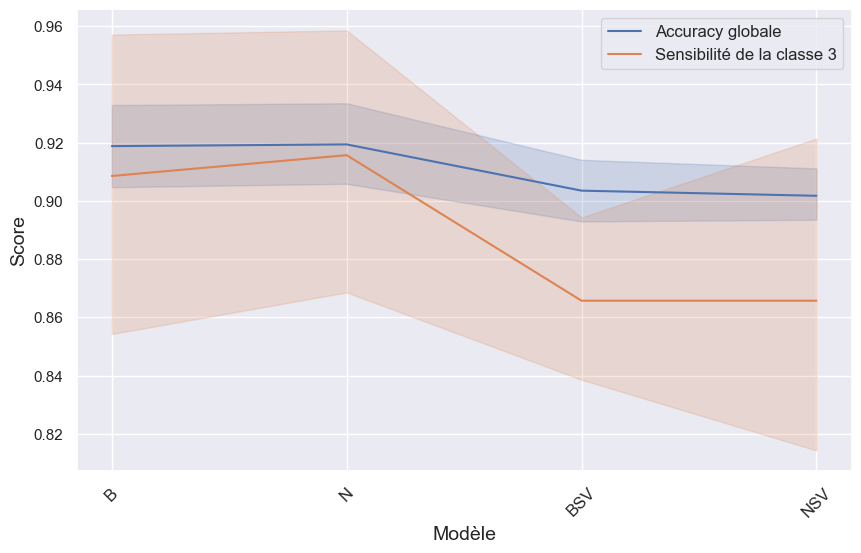

In [18]:
results_tree = {}

for pipeline_name, pipeline in tree_models:
    print(pipeline_name)
    results_tree[pipeline_name] = evaluate_model(
        pipeline, 
        DecisionTreeClassifier(criterion='entropy', class_weight='balanced'), 
        X_train, 
        y_train, 
        X_test, 
        y_test
    )
    pp(results_tree[pipeline_name])
    print()


model_names = []
accuracies = []
recalls = []

for model_name, result in results_tree.items():
    model_names.extend([model_name] * len(result["accuracies"]))
    accuracies.extend(result["accuracies"])
    recalls.extend(result["recalls_path"])


df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "Recall": recalls
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Model", y="Accuracy", label="Accuracy globale")
sns.lineplot(data=df, x="Model", y="Recall", label="Sensibilité de la classe 3")
plt.xlabel("Modèle",  fontsize=14)
plt.ylabel("Score",  fontsize=14)
plt.xticks(rotation=45,  fontsize=12)
plt.legend( fontsize=12)
plt

Meilleure Arbre : données brutes, class_weights: balanced.
Accuracy globale (CrossVal) : 0.919
Rappel classe Pathological (CrossVal) : 0.909

Matrice de confusion :


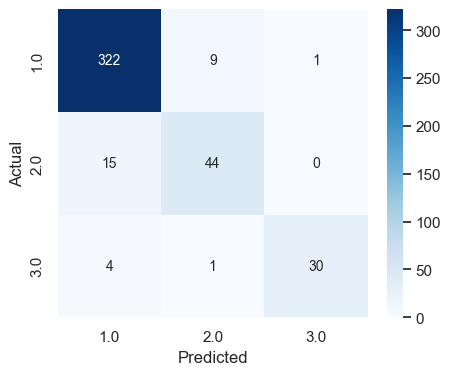

Rapport de classification sur le jeu de test : 
              precision    recall  f1-score   support

         1.0       0.94      0.97      0.96       332
         2.0       0.81      0.75      0.78        59
         3.0       0.97      0.86      0.91        35

    accuracy                           0.93       426
   macro avg       0.91      0.86      0.88       426
weighted avg       0.93      0.93      0.93       426



In [19]:
best_tree = results_tree["B"]
print("Meilleure Arbre : données brutes, class_weights: balanced.")
print(f"Accuracy globale (CrossVal) : {np.mean(best_tree['accuracies']):.3f}")
print(f"Rappel classe Pathological (CrossVal) : {np.mean(best_tree['recalls_path']):.3f}\n")

pipeline = Pipeline([
        ("Standardization", FunctionTransformer(validate=True))
])

X_train_processed = pipeline.fit_transform(X_train, y_train)

best_model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced')
best_model.fit(X_train_processed, y_train)

X_test_processed = pipeline.transform(X_test)

y_test_pred = best_model.predict(X_test_processed)

print("Matrice de confusion :")
cm = confusion_matrix(y_test, y_test_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,4))
sns.set(font_scale=1)
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='d', annot_kws={"size": 10})
plt.show()

print("Rapport de classification sur le jeu de test : ")
print(classification_report(y_test, y_test_pred))

## Résultats finaux Cross Validation

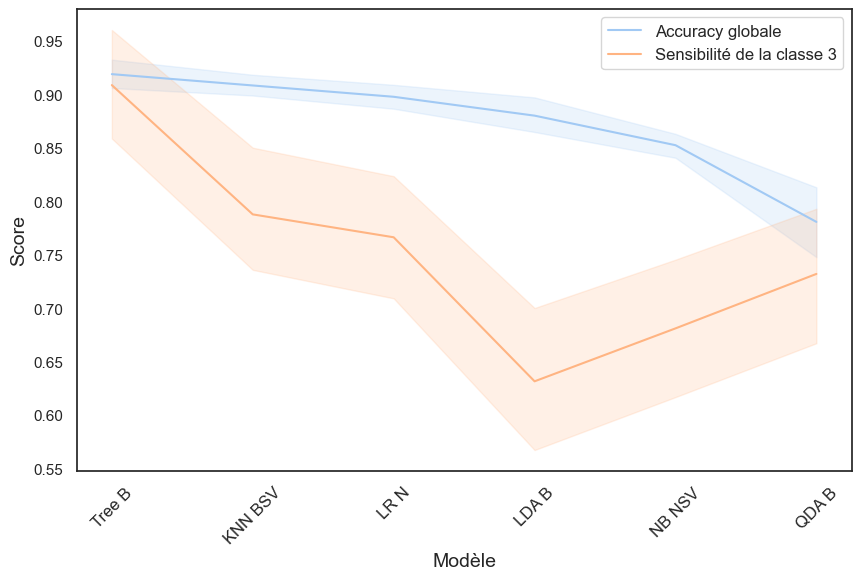

In [20]:
results_all = {
    "KNN BSV": best_knn, 
    "LDA B": best_lda, 
    "QDA B": best_qda, 
    "NB NSV": best_nb, 
    "LR N": best_lr,
    "Tree B": best_tree
}

mean_accuracies = {name: np.mean(result["accuracies"]) for name, result in results_all.items()}
sorted_models = sorted(mean_accuracies, key=mean_accuracies.get, reverse=True)

model_names = []
accuracies = []
recalls = []

# Iterate over the sorted models
for model_name in sorted_models:
    result = results_all[model_name]
    model_names.extend([model_name] * len(result["accuracies"]))
    accuracies.extend(result["accuracies"])
    recalls.extend(result["recalls_path"])

df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "Recall": recalls
})

sns.set_style("white")
sns.set_palette(sns.color_palette("pastel"))

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Model", y="Accuracy", label="Accuracy globale")
sns.lineplot(data=df, x="Model", y="Recall", label="Sensibilité de la classe 3")
plt.xlabel("Modèle",  fontsize=14)
plt.ylabel("Score",  fontsize=14)
plt.xticks(rotation=45,  fontsize=12)
plt.legend( fontsize=12)
plt.show()

Légende : 
- B → Brutes
- N → Normalisées
- SV → avec Selection de variables

Avec la cross-validation, on a la confirmation que les arbres de décisions sont meilleurs à tout point de vue

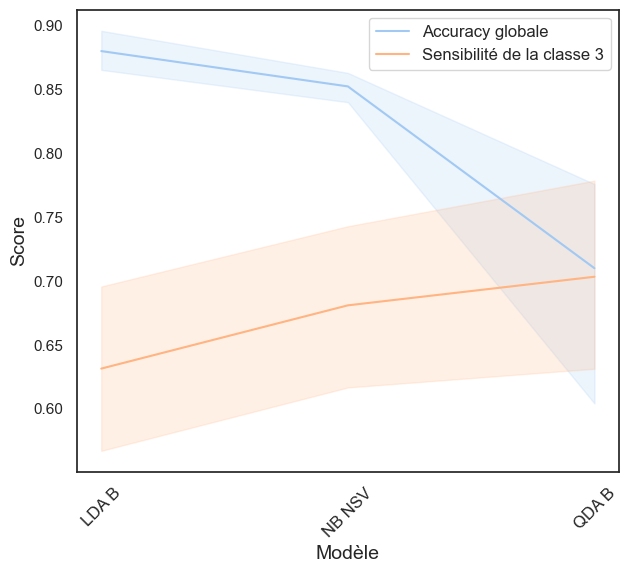

In [29]:
results_all = {
    "LDA B": best_lda, 
    "QDA B": best_qda, 
    "NB NSV": best_nb, 
}

mean_accuracies = {name: np.mean(result["accuracies"]) for name, result in results_all.items()}
sorted_models = sorted(mean_accuracies, key=mean_accuracies.get, reverse=True)

model_names = []
accuracies = []
recalls = []

# Iterate over the sorted models
for model_name in sorted_models:
    result = results_all[model_name]
    model_names.extend([model_name] * len(result["accuracies"]))
    accuracies.extend(result["accuracies"])
    recalls.extend(result["recalls_path"])

df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "Recall": recalls
})

sns.set_style("white")
sns.set_palette(sns.color_palette("pastel"))

plt.figure(figsize=(7, 6))
sns.lineplot(data=df, x="Model", y="Accuracy", label="Accuracy globale")
sns.lineplot(data=df, x="Model", y="Recall", label="Sensibilité de la classe 3")
plt.xlabel("Modèle",  fontsize=14)
plt.ylabel("Score",  fontsize=14)
plt.xticks(rotation=45,  fontsize=12)
plt.legend( fontsize=12)
plt.show()

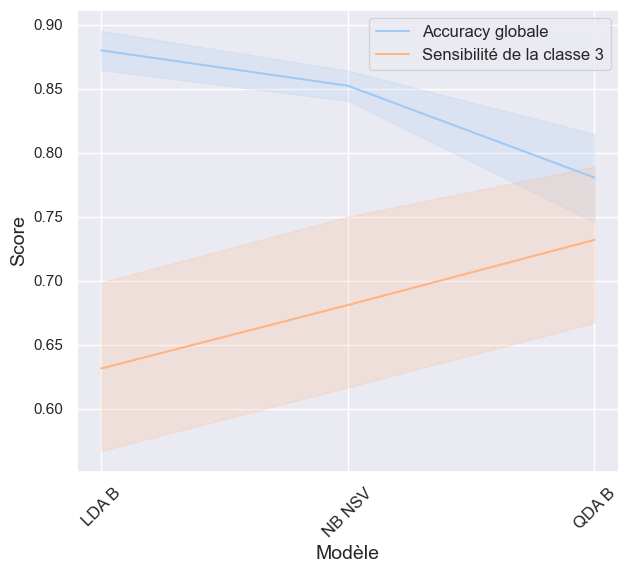

In [26]:
results_all = {
    "LDA B": best_lda, 
    "QDA B": best_qda, 
    "NB NSV": best_nb, 
}

mean_accuracies = {name: np.mean(result["accuracies"]) for name, result in results_all.items()}
sorted_models = sorted(mean_accuracies, key=mean_accuracies.get, reverse=True)

model_names = []
accuracies = []
recalls = []

# Iterate over the sorted models
for model_name in sorted_models:
    result = results_all[model_name]
    model_names.extend([model_name] * len(result["accuracies"]))
    accuracies.extend(result["accuracies"])
    recalls.extend(result["recalls_path"])

df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "Recall": recalls
})

# sns.set_style("white")
# sns.set_palette(sns.color_palette("pastel"))

plt.figure(figsize=(7, 6))
sns.lineplot(data=df, x="Model", y="Accuracy", label="Accuracy globale")
sns.lineplot(data=df, x="Model", y="Recall", label="Sensibilité de la classe 3")
plt.xlabel("Modèle",  fontsize=14)
plt.ylabel("Score",  fontsize=14)
plt.xticks(rotation=45,  fontsize=12)
plt.legend( fontsize=12)
plt.show()